In [1]:
import numpy as np
from scipy.stats import multivariate_normal as mvn
import matplotlib.pylab as plt
import sys
sys.path.insert(0, '../zdrojaky/kf')
from kf import KF
from trajectory import trajectory
np.set_printoptions(precision=2)


Bad key "xtick.alignment" on line 250 in
/usr/share/matplotlib/mpl-data/stylelib/classic.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution

Bad key "ytick.alignment" on line 268 in
/usr/share/matplotlib/mpl-data/stylelib/classic.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


# Cvičení 5: Sledování objektu ve 2D pomocí particle filtru

Cílem tohoto cvičení je filtrace polohy objektu pohybujícího se na ploše, tj. ve 2D, tentokrát ale particle filtrem. Jelikož uvažujeme lineární model, je to trochu kladivo na komára, ale uvidíme, že funguje dobře.

Cílem je odhadovat stavový vektor sestávající se z polohy v osách $x_1$ a $x_2$ a rychlostech v obou těchto osách.

$$
x_t =
\begin{bmatrix}
x_{1,t} \\ 
x_{2,t} \\ 
v_{x_1,t} \\ 
v_{x_2,t}
\end{bmatrix}
$$

Víme, že pro polohu v první ose platí

$$
x_{1,t} = x_{1,t-1} + v_{x_1,t} dt + w_{x_1,t},
$$

a že analogicky platí totéž i pro polohu v ose druhé. Abychom se nemuseli zaobírat zrychlením, budeme uvažovat, že rychlost je stejná a její změny jsou způsobeny jen šumem,

$$
v_{x_1,t} = v_{x_1, t-1} + w_{vx_1, t}.
$$

Analogicky pro druhou složku rychlosti. K dispozici jsou jen měření polohy v obou osách a to v časovém kroku 0.1s.

Potřebujeme tedy sestavit stavový model

$$
\begin{aligned}
x_t &\sim \mathcal{N}(Ax_{t-1} + Bu_t, Q),\\
y_t &\sim \mathcal{N}(Hx_{t}, R).
\end{aligned}
$$

Kovarianční matice nám musí někdo dodat, níže jsou uvedeny.

\begin{align*}
    A &=
    \begin{bmatrix}
       1 & 0 & dt & 0 \\
       0 & 1 & 0 & dt \\
       0 & 0 & 1 &  0 \\
       0 & 0 & 0 &  1 
    \end{bmatrix},
    \quad
    &Q &= q\cdot
    \begin{bmatrix}
        \frac{dt^3}{3}    & 0                 & \frac{dt^{2}}{2}  & 0  \\
        0                 & \frac{dt^3}{3}    & 0                 & \frac{dt^{2}}{2} \\
        \frac{dt^{2}}{2}  & 0                 & dt                & 0 \\
        0                 & \frac{dt^{2}}{2}  & 0                 & dt
    \end{bmatrix}
    \notag \\
    H &=
    \begin{bmatrix}
        1 & 0 &0 & 0 \\
        0 & 1 &0 & 0
    \end{bmatrix}
    \quad
    &R &=
    r^{2}\cdot
    \begin{bmatrix}
        1 & 0 \\
        0 & 1
    \end{bmatrix}
\end{align*}
kde $dt = 0.1$, $q = 2$, $r=0.5$.

** Úkol: doplňte chybějící proměnné**

In [2]:
q = 2.
dt = .1
r = .2
A = np.array([[1, 0, dt, 0],
              [0, 1, 0, dt],
              [0, 0, 1,  0],
              [0, 0, 0,  1]])
Q = q * np.array([[dt**3/3, 0      , dt**2/2, 0      ],
                  [0,       dt**3/3, 0,       dt**2/2],
                  [dt**2/2, 0,       dt,      0      ],
                  [0,       dt**2/2, 0,       dt     ]])
H = np.array([[1., 0, 0, 0],
              [0., 1, 0, 0]])
R = r**2 * np.eye(2)

**Úkol: doplňte za `code` den a měsíc svého svátku. V objektu `traj` budete mít trajektorii o 100 řádcích, v každém je poloha v obou osách. Vykreslete ji křížky.**

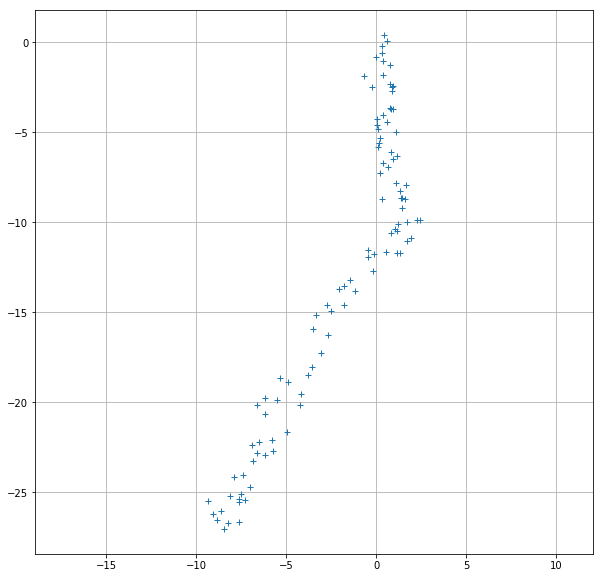

In [3]:
code = 1313
traj = trajectory(code)
plt.figure(figsize=(10, 10))
plt.plot(traj.Y[0,:], traj.Y[1,:], '+')
plt.axis('equal')
plt.show()

**Úkol: Dodefinujte proposal distribuci - bude N(0, 10I). Znormalizujte vektor vah.**

In [4]:
ndat = traj.ndat
nsamples = 1000
proposal_loc = np.zeros(4)
proposal_cov = 10 * np.eye(4)

samples_x = mvn.rvs(mean=proposal_loc, cov=proposal_cov, size=nsamples)
weights = np.ones(nsamples)
weights /= weights.sum()
print("Kontrola vah: 1 =", weights.sum())

Kontrola vah: 1 = 1.0


**Úkol: doplňte funkce kde jsou `###` **

In [5]:
# Logs
log_x = np.zeros((4, ndat))

def prediction(samples_x):
    samples_x_new = np.zeros_like(samples_x)
    for i in range(nsamples):
        mean = A.dot(samples_x[i])
        samples_x_new[i] = mvn.rvs(mean=mean, cov=Q)
    return samples_x_new

def update(yt, samples_x, weights):
    for i in range(nsamples):
        mean = H.dot(samples_x[i])
        likelihood = mvn.pdf(yt, mean=mean, cov=R)
        weights[i] *= likelihood
    weights /= weights.sum()
    return weights

def resample(samples_x, weights):
    indices = np.random.choice(np.arange(weights.size), replace=True, p=weights, size=weights.size)
    samples_x_new = samples_x[indices]
    weights = np.ones_like(weights)/weights.size
    return [samples_x_new, weights]

In [6]:
for t, yt in enumerate(traj.Y.T):
    
    # Resampling
    samples_x, weights = resample(samples_x, weights)
    
    # Prediction
    samples_x = prediction(samples_x)

    # Update
    weights = update(yt, samples_x, weights)
    
    # Estimate & log
    estimate = np.sum(samples_x * weights[:,np.newaxis], axis=0)
    log_x[:,t] = estimate

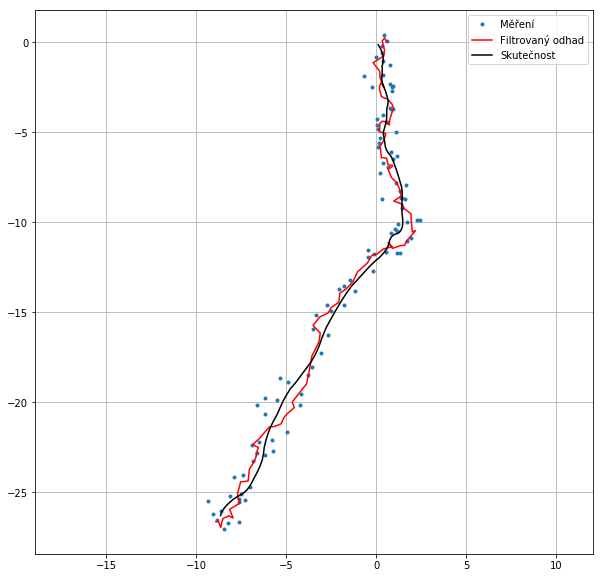

In [7]:
plt.figure(figsize=(10,10))
plt.plot(traj.Y[0,:], traj.Y[1,:], '.', label='Měření')
plt.plot(log_x[0,:], log_x[1,:], '-', color='red', label='Filtrovaný odhad')
plt.plot(traj.X[0,:], traj.X[1,:], 'k', label='Skutečnost')
plt.grid(True)
plt.axis('equal')
plt.legend()
plt.show()

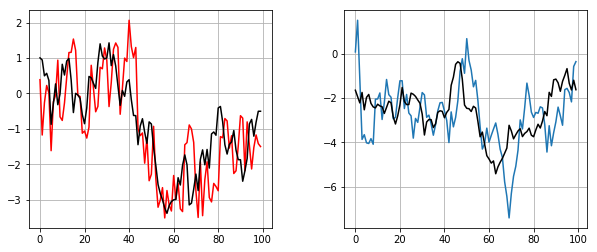

In [8]:
plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
plt.plot(log_x[2,:], 'r')
plt.plot(traj.X[2,:], 'k')
plt.subplot(1,2,2)
plt.plot(log_x[3,:])
plt.plot(traj.X[3,:], 'k')
plt.show()